In [181]:
# Abaikan kode berikut
from IPython.display import Image

# Chapter 3 - Deteksi Bola

Salah satu aturan yang ada dalam guidebook lomba KSRBI adalah mengatur warna bola, lapangan dan beberapa objek di lapangan. Bola sendiri yang merupakan objek paling penting di permainan di-'_color coded_' dengan warna oranye. Kita dapat memanfaatkan 'fitur' warna ini untuk deteksi bola.

Ada banyak cara untuk mencari suatu objek di dalam citra, mulai dari metode HSV seperti ini, pencarian bentuk lingkaran di gambar, hingga Machine Learning seperti CNN. Semakin kompleks metode yang digunakan biasanya hasil yang didapatkan akan semakin baik, namun hal ini akan mengorbankan lama pemrosesan.

Misal dengan metode HSV analitikal, posisi bola dapat ditentukan dengan 'buruk' dalam waktu 1ms dibandingkan dengan metode Machine Learning yang memerlukan waktu 300ms, maka metode HSV akan dipilih mengingat aplikasi dari pengolahan citra adalah sebuah robot yang perlu bereaksi secara real time terhadap lingkungannya.

Dalam dunia nyata, sayangnya tidak ada hasil deteksi yang sempurna (Bahkan menggunakan Machine Learning sekalipun) yang memiliki akurasi hingga 100%, maka metode yang digunakan biasanya berlapis. Dalam pembahasan modul ini kita akan mencoba mencari objek berwarna oranye di dalam sebuah citra gambar.

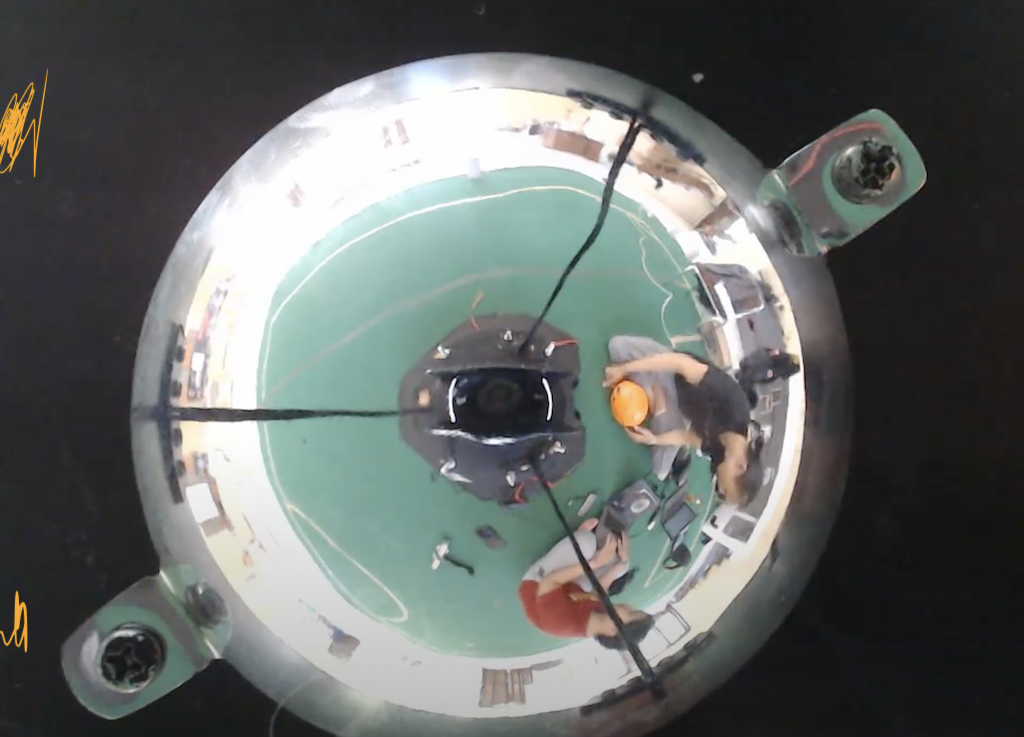

In [15]:
Image("./sample/get_ball.png", width=500)

Frame citra yang dimaksud dapat diambil dari file gambar, frame video, atau frame webcam. Misalkan didapatkan sebuah frame citra seperti gambar diatas yang didapatkan dari kamera omnivision dari Robot Beroda Gandiwa.

Dapat dilihat beberapa ciri-ciri dari citra yang perlu diperhatikan yaitu:
-. Bola berwarna oranye jelas, namun ada cahaya yang mengenainya menyebabkan warna oranye ter-gradient (Ada area terang, ada area gelap)
-. Ada tiga tiang penyangga di arah jam 1, arah jam 5 dan arah jam 9 yang mengganggu jarak pandang dari robot
-. Ada distorsi pada gambar, tepatnya di tiang arah jam 1
-. Ada efek bloom (Cahaya yang terlalu terang) di arah jam 10 hingga arah jam 12
-. Area yang menampilkan arena dan bola hanya terletak di sebuah lingkaran, dan sisanya hanyalah frame dari robot yang dapat diabaikan seperti baut
-. Ada coretan berwarna oranye di sisi kiri citra yang warnanya sangat mirip dengan bola
dst

Beberapa observasi diatas dapat diatasi secara software (Misal warna bola yang terkena cahaya tidak sempurna oranye), namun banyak juga yang tidak dapat diatasi secara software seperti bloom cahaya. Bloom cahaya ini hanya dapat diatasi dengan mengurangi cahayanya, salah satunya dengan menutup sumber cahaya.

# Chapter 3.1 Deteksi Bola dengan Photoshop

Mengingat kembali ke nama bidang pengolahan citra, nama 'pengolahan citra' merujuk ke segala pemrosesan yang dilakukan pada sebuah gambar. Ingat kembali bahwa aplikasi editing seperti Adobe Photoshop, Inkspace, Affinity Designer juga termasuk 'pengolahan citra'

Jadi implementasi kode dari 'pengolahan citra' bisa kita analogikan dengan proses-proses di aplikasi editing, yang akan kita lakukan sekarang dengan tujuan mempelajari proses yang akan kita lakukan, tanpa harus memikirkan bagaimana menuliskan kodenya

"Memilih bola yang memiliki warna oranye", di Photoshop dapat dilakukan dengan fitur __Select__ > __Color Range__. Perhatikan bahwa yang kita 'select' adalah 'color __range__', yaitu sekumpulan warna direntang tertentu, dan bukan cuma 1 warna saja (Persis seperti warna bola oranye yang terkena cahaya menjadi lebih putih, dan tidak terkena cahaya menjadi lebih gelap)

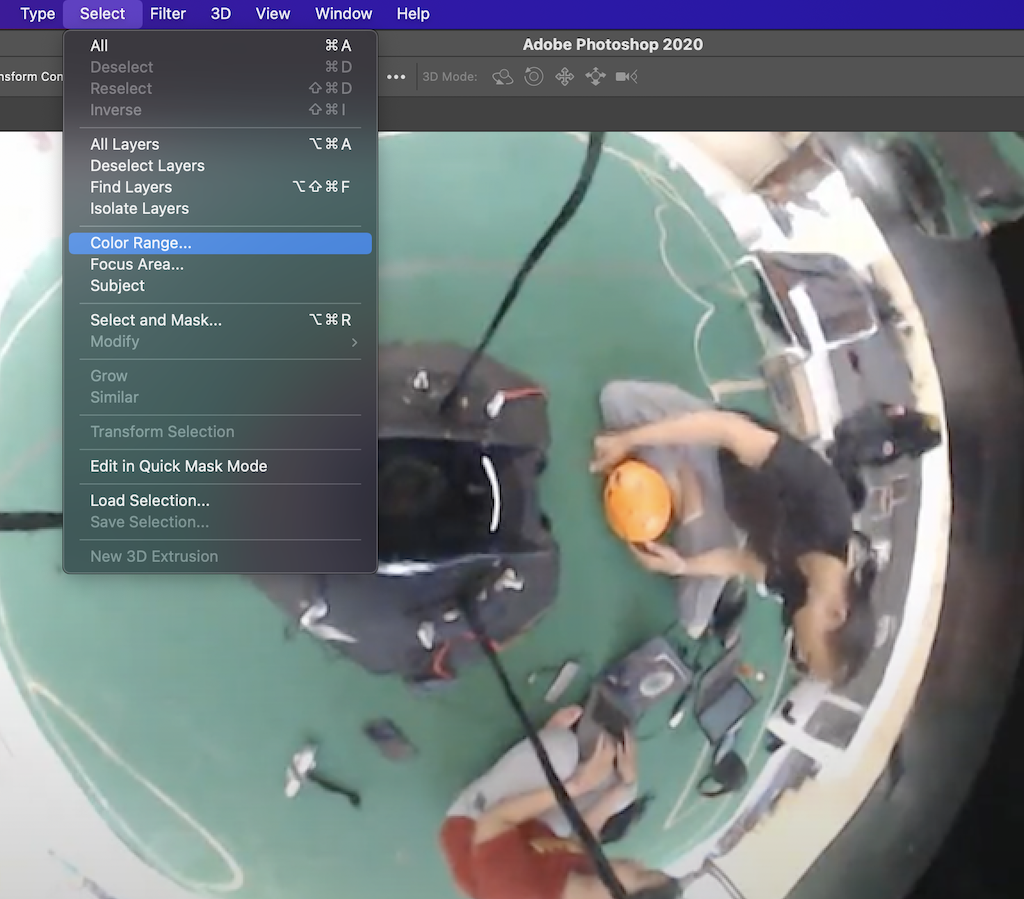

In [182]:
Image("./assets/color_range_psd.png", width=500)

Menu __Color Range__ memerlukan beberapa parameter, yaitu sebuah "Sample" dan "Fuzziness"

Sample merujuk ke 1 warna spesifik, kita sampel dari salah satu piksel dari gambar. Fuzziness adalah tingkat toleransi dari warna, jika dikalimatkan fuzziness dapat diartikan sebagai "seberapa jauh dari _sample_ warna yang ditoleransi". Semakin tinggi fuzziness, semakin luas warna yang diterima.

Hasil dari proses ini adalah sebuah mask (Dapat dilihat di kotak dibawah input parameter), 

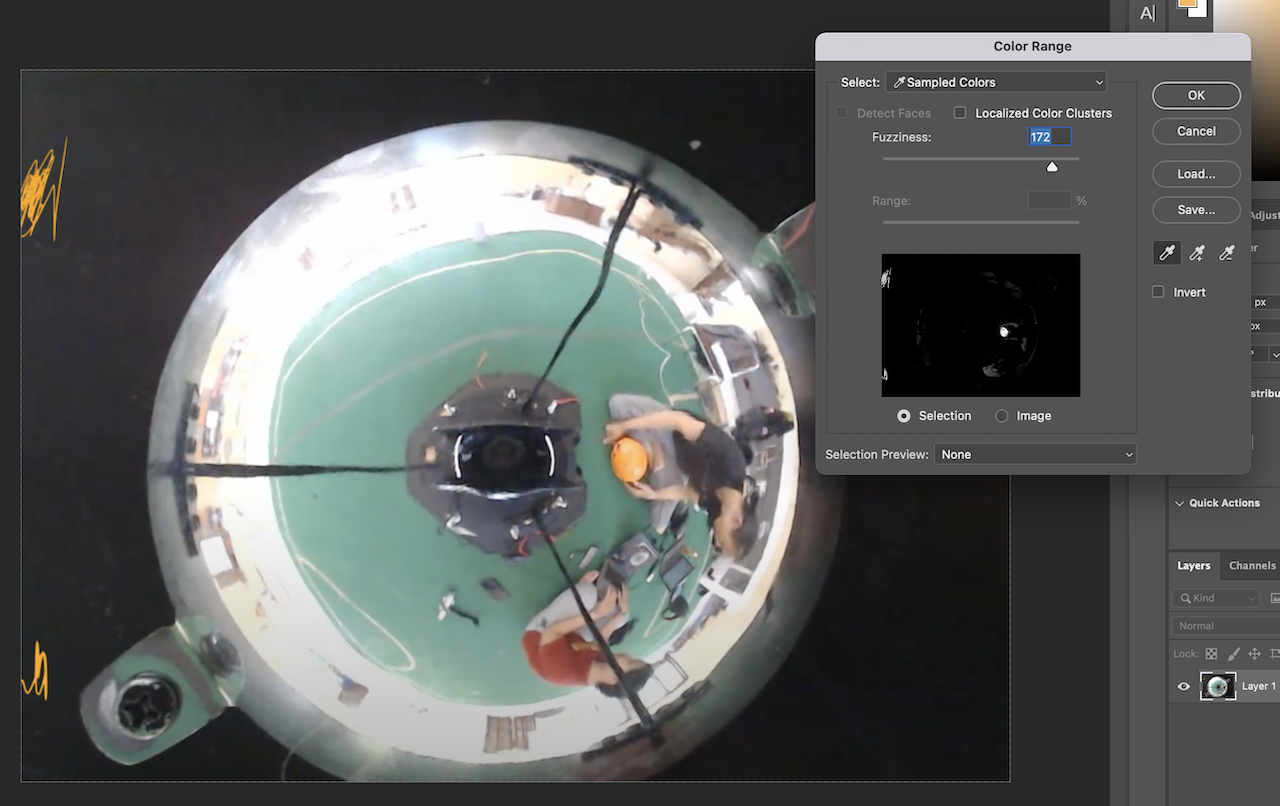

In [18]:
Image("./assets/color_ranged_psd.png", width=800)

Proses dari deteksi bola mempergunakan warna kurang lebih dapat dilakukan dengan cara seperti diatas. Tentunya dengan proses tambahan untuk mengekstrak informasi dari mask untuk mendapatkan kordinat dari glob putih

Sekarang kita mengetahui bagaimana analogi dari deteksi objek dengan warna, bagaimana kita mengimplementasikannya dalam bentuk kode Python?

# Chapter 3.2 Pemilihan Range HSV

Pemilihan warna di Photoshop dapat dilakukan dengan mudah dengan mengklik piksel, proses yang mirip dapat kita lakukan untuk mengambil Range HSV kita, yaitu dengan memanfaatkan __Color Picker__ di Photoshop

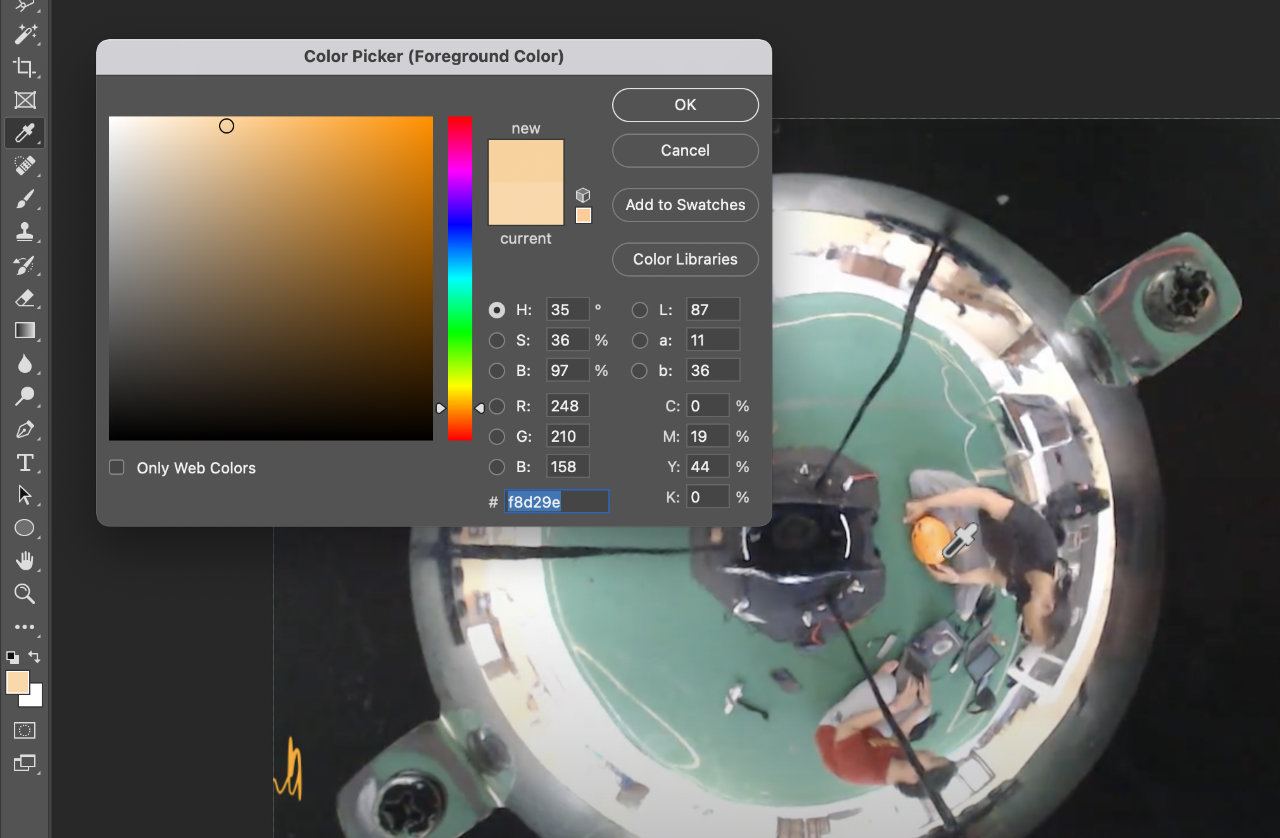

In [185]:
Image("assets/color_picker.jpg", width=600)

Dengan mempergunakan fitur Color Picker dari Photoshop, kita menemukan nilai HSB yaitu H=35˚, S=36%, B=97%. Perhatikan bahwa nama color space yang digunakan berbeda (HSV dan HSB), perhatikan juga satuan yang dipergunakan

Disini kita menemukan beberapa detail implementasi dan konvensi yang berbeda dari OpenCV yang berbeda dari aplikasi lain. Sebelumnya kita menemukan bahwa aplikasi yang biasa kita gunakan menggunakan nilai RGB, namun ternyata OpenCV memiliki urutan warna yang agak berbeda yaitu BGR.

HSB dan HSV, huruf B (Brighness) dan V (Value) merujuk ke hal yang sama, yaitu kecerahan. Jadi hanya perbedaan dari nama ke hal yang sama*

Selanjutnya dapat dilihat satuan yang digunakan oleh Photoshop juga 'aneh', yaitu persen dan derajat dimana kedua satuan ini relatif terhadap nilai tertentu. Derajat relatif ke 360˚, dan persen relatif ke 100%

OpenCV mempergunakan rentang yang sedikit berbeda, yaitu rentang H adalah 0-179, lalu S dan V dari 0-255. Jadi nilai HSB yang kita dapatkan dari Photoshop perlu diubah terlebih dahulu rentangnya**

----

*Perhatikan bahwa ada color space HSL, dimana L (Luminance) merujuk ke konsep yang sedikit berbeda dari kecerahan

** Kenapa OpenCV mempergunakan nilai maksimal 179 dan bukan 360? Hal ini terjadi karena OpenCV menyimpan nilai angka di 8bit, sehingga nilai maksimal adalah 255

Untuk menyederhanakan modul, maka pemilihan range HSV dapat dilakukan dengan bantuan tool berikut [https://github.com/hariangr/HsvRangeTool](https://github.com/hariangr/HsvRangeTool), untuk penjelasan penggunaan tool dapat dilihat di video berikut [https://www.youtube.com/watch?v=mmebr5PGbqo](https://www.youtube.com/watch?v=mmebr5PGbqo)

Untuk selanjutnya kita gunakan rentang HSV sebagai berikut 
```
upper_orange = [33, 255, 255]
lower_orange = [3, 120, 112]
```

Perhatikan bahwa parameter-paremeter seperti range nilai HSV, Erode, Dilate, dan parameter lain tidak bersifat konkret, nilai-nilai ini perlu disesuaikan seiring dengan perkembangan robot, kamera, ruangan, dls

# Chapter 3.3 Implementasi OpenCV

Selanjutnya kita dapat mencoba melakukan implementasi dengan memanfaatkan materi-materi yang sudah kita pelajari dari Chapter sebelumnya

In [29]:
# Lakukan import opencv
import cv2

# Library untuk membantu
import numpy as np # Melakukan operasi matriks
import matplotlib.pyplot as plt # Menampilkan grafik

In [187]:
# Fungsi berikut berfungsi untuk menampilkan hasil kalkulasi ke modul ini
# Dapat diabaikan
def tampilkan_gambar_di_modul(img):
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

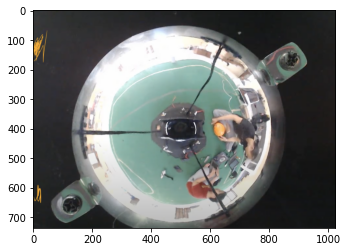

In [31]:
# Load citra kedalam variabel
raw_frame = cv2.imread("./sample/get_ball.png")

tampilkan_gambar_di_modul(raw_frame)

In [188]:
# Inisiasi range warna yang ingin digunakan (Hasil chapter 3.2)
upper_orange = np.array([33, 255, 255])
lower_orange = np.array([3, 120, 112])

# Perhatikan bahwa nilai-nilai di upper lebih besar dari nilai-nilai di lower

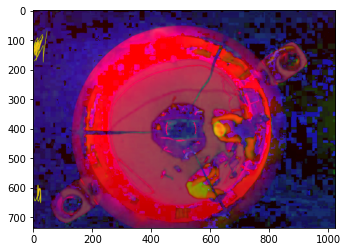

In [42]:
hsv_frame = cv2.cvtColor(raw_frame, cv2.COLOR_BGR2HSV) # Ubah color space dari BGR ke HSV

tampilkan_gambar_di_modul(hsv_frame)

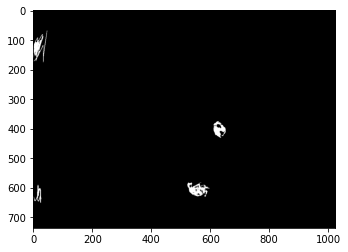

In [44]:
# Pilih warna yang ada diantara range `upper` dan `lower` HSV
orange_mask = cv2.inRange(hsv_frame, lower_orange, upper_orange)

tampilkan_gambar_di_modul(orange_mask)

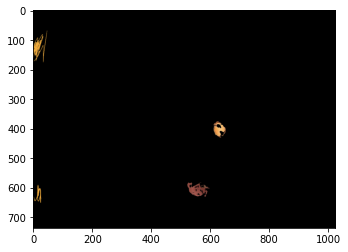

In [46]:
# Visualisasikan mask dengan gambar raw
visualize = cv2.bitwise_and(raw_frame, raw_frame, mask=orange_mask) # Tampilkan warna-warna oranye yang terdeteksi

# Perhatikan bahwa warna bola yang terdeteksi tidak sempurna (Ada warna oranye yang hilang dari bola)
tampilkan_gambar_di_modul(visualize)

Warna oranye di temukan di (x, y): ( 576 , 620 )
Warna oranye di temukan di (x, y): ( 0 , 591 )
Warna oranye di temukan di (x, y): ( 521 , 583 )
Warna oranye di temukan di (x, y): ( 568 , 582 )
Warna oranye di temukan di (x, y): ( 610 , 376 )
Warna oranye di temukan di (x, y): ( 0 , 69 )


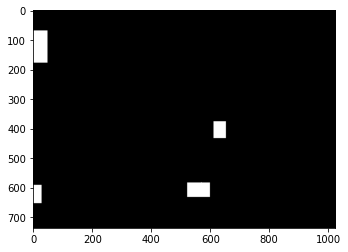

In [57]:
contours, _ = cv2.findContours(orange_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # Ambil kontur dari setiap glob warna putih

for contour in contours:
    M = cv2.moments(contour) # Kalkulasikan moment
    bbox = cv2.boundingRect(contour) # Ambil bounding box
    
    x, y, w, h = bbox # Ambil kordinat dan panjang, lebar dari bounding box
    
    print("Warna oranye di temukan di (x, y): (", x, "," , y, ")")
    # Visualisasikan, perhatikan opencv memerlukan xyxy (Titik kiri atas dan kanan bawah),
    # sedangkan bbox yang kita dapatkan adalah xywh (Titik kiri atas dan panjang lebar)
    cv2.rectangle(visualize, (x, y), (x+w, y+h), (255, 255, 255), -1) 
    
tampilkan_gambar_di_modul(visualize)

Bounding Box adalah sebuah persegi yang dapat mengelilingi objek secara penuh

Contours dan moment adalah kalkulasi matematika kompleks yang tidak perlu kita ketahui, namun dapat dijelaskan sebagai berikut: Contours adalah garis yang dihubungkan semua 'point' dari sebuah objek. Moment disini adalah moment yang sama di Fisika, dalam konteks ini adalah rata-rata titik tengah dari titik yang menyusun objek

# Chapter 3.4 (Tambahan) - Mengurangi Noise Dengan Morphology Opening

Dapat dilihat hasil print dari setiap kontur yang kita lakukan menghasilkan 6 kordinat, namun mata manusia hanya dapat melihat 4 objek putih di mask, kenapa?

Hal ini dapat terjadi karena mungkin ada bounding box yang berukuran sangat kecil (Bahkan mungkin 1x1 piksel) hingga tak dapat dilihat mata manusia. Namun untuk aplikasi yang akan kita lakukan, piksel-piksel kecil ini dapat kita anggap sebagai noise dan boleh difilter (Hapus)

Cara penghapusan yang akan kita lakukan adalah dengan melakukan Erosi dan Dilasi (Morphology Opening). Erosi dapat dianggap sebagai mengurangi piksel-piksel pinggir objek, dan dilasi dapat dianggap sebagai memperluas piksel-piksel pinggir objek.

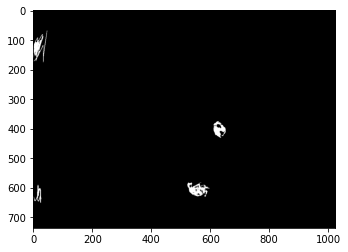

In [195]:
# Pilih warna yang ada diantara range `upper` dan `lower` HSV
raw_frame = cv2.imread("./sample/get_ball.png")
hsv_frame = cv2.cvtColor(raw_frame, cv2.COLOR_BGR2HSV)
orange_mask = cv2.inRange(hsv_frame, lower_orange, upper_orange)

tampilkan_gambar_di_modul(orange_mask)

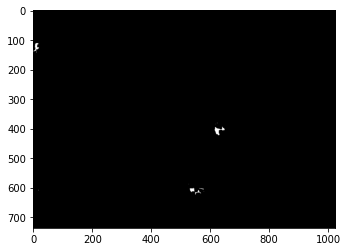

In [199]:
# Lakukan erosi, perhatikan bahwa area setiap objek semakin menyempit
# Parameter erosi (7), dipilih dengan cara 'coba-coba'
eroded_frame = cv2.erode(orange_mask, np.ones((7, 7), dtype=np.uint8))

tampilkan_gambar_di_modul(eroded_frame)

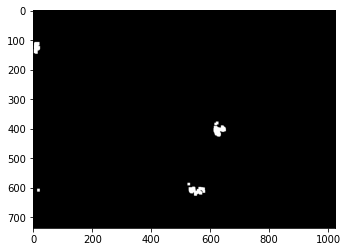

In [200]:
# Lakukan dilasi, perhatikan bahwa area setiap objek semakin meluas
# Piksel-piksel yang sangat sempit (1x1 piksel misalnya) sudah hilang dari proses erosi sebelumnya
dilated_frame = cv2.dilate(eroded_frame, np.ones((9, 9), dtype=np.uint8))

tampilkan_gambar_di_modul(dilated_frame)

Warna oranye di temukan di (x, y): ( 0 , 591 )
Warna oranye di temukan di (x, y): ( 521 , 583 )
Warna oranye di temukan di (x, y): ( 610 , 376 )
Warna oranye di temukan di (x, y): ( 0 , 69 )


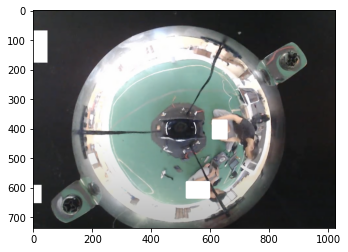

In [201]:
contours, _ = cv2.findContours(orange_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

for contour in contours:
    M = cv2.moments(contour)
    
    area = cv2.contourArea(contour) # Ambil luas area dari setiap objek
    if area > 20: # Objek yang luas areanya kurang dari 20unit akan kita abaikan
        bbox = cv2.boundingRect(contour)
        x, y, w, h = bbox
        print("Warna oranye di temukan di (x, y): (", x, "," , y, ")")
        cv2.rectangle(visualize, (x, y), (x+w, y+h), (255, 255, 255), -1)
    
tampilkan_gambar_di_modul(visualize)

Teknik-teknik yang dilakukan untuk menghilangkan noise tidak hanya 1, berbeda tergantung dari jenis aplikasi yang diinginkan dan toleransi dari hasil filter yang dilakukan.

Melakukan morphology opening lalu memfilter yang luas areanya terlalu kecil hanya salah satu diantaranya.

Ada 4 objek yang terdeteksi di tahap ini, termasuk 3 noise yaitu 2 objek diluar lapangan, dan 1 objek berupa baju

Baju dapat difilter dengan menyempitkan toleransi range HSV yang kita pilih, lalu untuk coretan diluar lapangan dapat kita lakukan dengan hanya memproses bagian tertentu dari citra seperti Chapter 3.5

# Chapter 3.5 (Tambahan) - Mengurangi Noise Dengan Region of Interest

Untuk mengurangi noise dari luar lapangan dapat kita lakukan dengan menghapus piksel-piksel dari objek yang dapat dipastikan diluar lapangan, dalam kasus ini adalah objek diluar lingkaran omnivision

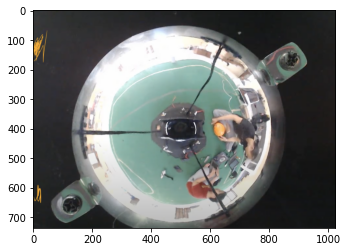

In [144]:
raw_frame = cv2.imread("./sample/get_ball.png")

tampilkan_gambar_di_modul(raw_frame)

Di chapter sebelumnya, mask kita buat mempergunakan aplikasi eksternal yaitu Photoshop. Di chapter ini kita akan membuat mask secara manual

In [145]:
# Ambil ukuran frame
raw_frame.shape

(737, 1024, 3)

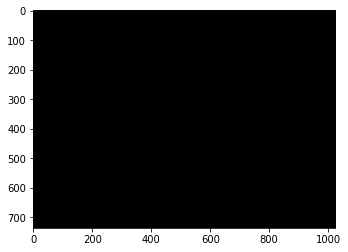

In [203]:
# Buat citra kosong dengan width dan height yang sama dengan raw frame
blank_roi = np.zeros((737, 1024), dtype='uint8') # uint8 menandakan bahwa nilai perpiksel hanya boleh antara 0 dan 255

plt.imshow(blank_roi, cmap='gray')

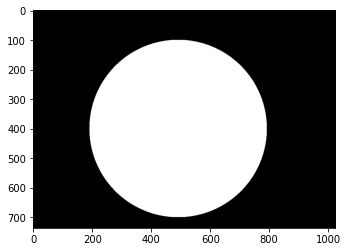

In [166]:
center_coordinates = (490, 400) # Dipilih dengan 'coba-coba'
radius = 300 # Besar dari lingkaran, dipilih dengan 'coba-coba'
color = (255,255,255) # Putih (Warna putih untuk foreground, hitam untuk background)
thickness = -1 # Kita akan memfill (Mengisi) tengah dari lingkaran dengan warna putih

roi_mask = blank_roi.copy()
cv2.circle(roi_mask, center_coordinates, radius, color, thickness)
plt.imshow(roi_mask, cmap='gray')

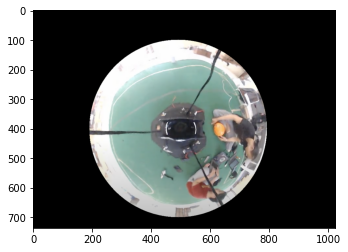

In [167]:
# Coba overlay
try_overlay = cv2.bitwise_and(raw_frame, raw_frame, mask=roi_mask) # Gunakan teknik masking

# Perhatikan bahwa citra baru yang kita dapatkan sudah menghilangkan semua piksel tidak penting yang dapat mengganggu
tampilkan_gambar_di_modul(try_overlay)

Warna oranye di temukan di (x, y): ( 519 , 581 )
Warna oranye di temukan di (x, y): ( 607 , 373 )


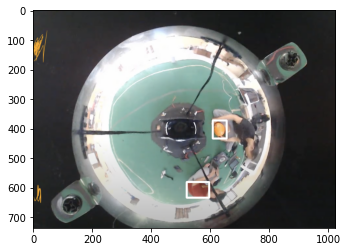

In [180]:
# Inisiasi range warna yang ingin digunakan (Hasil chapter 3.2)
upper_orange = np.array([33, 255, 255])
lower_orange = np.array([3, 120, 112])

hsv_frame = cv2.cvtColor(try_overlay, cv2.COLOR_BGR2HSV)
tampilkan_gambar_di_modul(hsv_frame)

# Pilih warna yang ada diantara range `upper` dan `lower` HSV
orange_mask = cv2.inRange(hsv_frame, lower_orange, upper_orange)
tampilkan_gambar_di_modul(orange_mask)

# Lakukan erosi
eroded_frame = cv2.erode(orange_mask, np.ones((3, 3), dtype=np.uint8))
tampilkan_gambar_di_modul(eroded_frame)

# Lakukan dilasi
dilated_frame = cv2.dilate(eroded_frame, np.ones((9, 9), dtype=np.uint8))
tampilkan_gambar_di_modul(dilated_frame)

visualize = raw_frame.copy()

contours, _ = cv2.findContours(dilated_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
for contour in contours:
    M = cv2.moments(contour)
    
    area = cv2.contourArea(contour)
    if area > 20:    
        bbox = cv2.boundingRect(contour)
        x, y, w, h = bbox
        print("Warna oranye di temukan di (x, y): (", x, "," , y, ")")
        cv2.rectangle(visualize, (x, y), (x+w, y+h), (255, 255, 255), 5)
    
tampilkan_gambar_di_modul(visualize)

# Chapter 3.5 (Tambahan) - Link

Implementasi robot KRSBI dalam bahasa Python
https://github.com/gandiwaberoda/BrainDead

Implementasi robot KRSBI dalam bahasa Golang
https://github.com/gandiwaberoda/BrainFreeze

Implementasi robot KRSBI dalam bahasa Rust
https://github.com/hariangr/Blossom (Diluar dari proyek Gandiwa)

Tool untuk memilih range warna HSV
https://github.com/hariangr/HsvRangeTool